In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install statsmodels
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 38.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


# Web Scraping "The Numbers" Website for additional movie revenue data

In [ ]:
#Data Scraping to get box_office_data_17489.csv
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape a single page
def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    data = []

    # Extracting table rows
    for row in table.find_all('tr'):
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        if cols:  # Only add non-empty rows
            data.append(cols)
    return data

# Base URL of the website to scrape
base_url = 'https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time-inflation-adjusted'

# Initialize empty list to hold all data
all_data = []

# Looping through multiple pages
# Adjust the range as needed based on the number of pages you need to scrape
for page_num in range(1, 11):  # Example: Scraping first 10 pages
    page_url = f"{base_url}/{(page_num-1)*100 + 1}"
    page_data = scrape_page(page_url)
    all_data.extend(page_data)

# Assuming the structure of all pages is the same, extracting headers from the first page
first_page_response = requests.get(base_url)
first_page_soup = BeautifulSoup(first_page_response.content, 'html.parser')
table_headers = [header.text.strip() for header in first_page_soup.find('table').find_all('th')]

# Convert to DataFrame
df = pd.DataFrame(all_data, columns=table_headers)

# Save to CSV
df.to_csv('box_office_data.csv', index=False)

# Print a message indicating completion
print("Data scraped and saved to box_office_data.csv")

# Data Loading

In [ ]:
movies_metadata = pd.read_csv("movies_metadata.csv")
tmdb_movies = pd.read_csv("tmdb-movies.csv")
box_office = pd.read_csv("box_office_data_17489.csv")

non_zero_imdb = (movies_metadata['revenue']!=0).sum()
print("imdb:", non_zero_imdb)

non_zero_tmdb = (tmdb_movies['revenue']!=0).sum()
print("tmdb:", non_zero_tmdb)

non_zero_box = (box_office['Total Box Office']!=0).sum()
print("box:", non_zero_box)

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
imdb: 7414
tmdb: 4850
box: 17500


# Data Preprocessing

In [ ]:
import re

# Function to clean movie titles
def clean_movie_title(title):
    title = title.lower()
    title = re.sub(r'\W+', '', title)
    return title

# Load and clean the datasets
movies_metadata = pd.read_csv("movies_metadata.csv")
tmdb_movies = pd.read_csv("tmdb-movies.csv")
box_office = pd.read_csv("box_office_data_17489.csv")

movies_metadata['original_title_lowercase'] = movies_metadata['original_title'].apply(clean_movie_title)
tmdb_movies['original_title_lowercase'] = tmdb_movies['original_title'].apply(clean_movie_title)
box_office['original_title_lowercase'] = box_office['Movie'].apply(clean_movie_title)

# Remove duplicates
movies_metadata = movies_metadata.drop_duplicates(subset=['imdb_id'])
tmdb_movies = tmdb_movies.drop_duplicates(subset=['original_title_lowercase'])
box_office = box_office.drop_duplicates(subset=['original_title_lowercase'])

# Merge using multiple keys
merged_movies = pd.merge(movies_metadata, tmdb_movies, on=['imdb_id', 'original_title_lowercase'], how='inner', suffixes=('_meta', '_tmdb'))
final_merged = pd.merge(merged_movies, box_office, on='original_title_lowercase', how='left')

# Check for duplicates in the final merged dataset
final_duplicates = final_merged[final_merged.duplicated(subset=['imdb_id', 'original_title_lowercase'], keep=False)]
#final_merged = final_merged[final_merged['revenue_adj'] != 0]
final_merged = final_merged[final_merged['original_language'] == 'en']

# Creating final revenue column containing all revenue values prioritizing box_office, then imdb, then tmdb revenue values (highest amount of revenues prioritized first)
final_merged['all_revenue'] = final_merged['Total Box Office']
mask1 = (final_merged['all_revenue'] == 0)
final_merged.loc[mask1, 'all_revenue'] = final_merged.loc[mask1, 'revenue_meta'] 
mask2 = (final_merged['all_revenue'] == 0)
final_merged.loc[mask2, 'all_revenue'] = final_merged.loc[mask2, 'revenue_tmdb'] 

# Creating budget column containing all budget values using imdb and tmdb values
final_merged['all_budget'] = final_merged['budget_meta'].astype(int)
mask1 = (final_merged['all_budget'] == 0)
final_merged.loc[mask1, 'all_budget'] = final_merged.loc[mask1, 'budget_tmdb'] 
mask2 = (final_merged['all_budget'] == 0)
final_merged = final_merged[final_merged['all_budget'] != 0]

# final_merged.value_counts('original_title_lowercase')

final_merged = final_merged.loc[(final_merged['all_revenue'] != 0) & (final_merged['all_revenue'].notna())]

# Convert the column to integers
final_merged['all_revenue'] = final_merged['all_revenue'].replace('[\$,]', '', regex=True).astype(int)

# Creating Seasons Column
final_merged['season'] = final_merged['release_date_meta'].str.extract(r"\-(.*?)\-")
final_merged = final_merged.astype({'season':'int'})

def season_categorizer(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

final_merged['season'] = final_merged['season'].apply(season_categorizer)

final_merged['genres_meta'] = final_merged['genres_meta'].str.extract(r"\{(.*?)\}")
final_merged['genres_meta'] = final_merged['genres_meta'].str.replace('\W', '')
# Change this code so that it can be rerun without running into error
final_merged['genres_meta'] = [re.findall('name(,?.*)', str(x)) for x in final_merged['genres_meta']]
final_merged['genres_meta'] = [''.join(l) for l in final_merged['genres_meta']]

# Function to convert string to integer
def convert_to_int(value):
    # Remove commas and convert to integer
    return int(value.replace(',', ''))

# Apply the function to the column
final_merged['Rank'] = final_merged['Rank'].apply(convert_to_int)

final_merged = final_merged.astype({'popularity_meta':'float'})

# Filtering the final_merged df to only include the columns we want in our models
cols_to_keep = ['all_revenue', 'all_budget', 'popularity_meta', 'vote_count_meta', 'season', 'Released', 'runtime_tmdb', 'vote_average_tmdb', 'Rank', 'genres_meta']
final_merged = final_merged[cols_to_keep]

# Removing the one instance of an empty genre to not run into column mismatch errors in CART model
final_merged = final_merged.loc[final_merged['genres_meta'] != ""]
final_merged

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_36/2602629362.py:71: FutureWarning: The default value of regex will change from True to False in a future version.
  final_merged['genres_meta'] = final_merged['genres_meta'].str.replace('\W', '')


,all_revenue,all_budget,popularity_meta,vote_count_meta,season,Released,runtime_tmdb,vote_average_tmdb,Rank,genres_meta
0,463309481,30000000,21.946943,5415.0,Fall,1995.0,81,7.5,105,Animation
1,241544869,65000000,17.015539,2413.0,Winter,1995.0,104,6.6,463,Adventure
3,160874676,16000000,3.859495,34.0,Winter,1995.0,127,6.1,902,Comedy
5,162057890,60000000,17.924927,1886.0,Winter,1995.0,171,7.5,892,Action
6,128536909,58000000,6.677277,141.0,Winter,1995.0,127,6.5,1223,Comedy
...,...,...,...,...,...,...,...,...,...,...
9604,17584489,1000000,14.992311,156.0,Fall,2016.0,95,6.6,5101,Comedy
9613,2004701,13000000,4.654312,48.0,Winter,2016.0,123,5.6,7900,Drama
9624,4123938,32000000,5.409525,29.0,Spring,1983.0,93,5.3,7011,Horror
9708,597809,1900000,1.483826,21.0,Spring,2015.0,89,7.4,9591,Drama


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

y = final_merged['all_revenue']
X = final_merged.loc[:, final_merged.columns != 'all_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    random_state=88,)
X_train.shape, X_test.shape

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Baseline Model

## OSR2 = 0.0 by definition

## RMSE = 120000832.45

In [ ]:
from sklearn.metrics import mean_squared_error

# Assuming y_true and y_pred are your actual and predicted values
y_baseline_pred = np.mean(y_train)

# Add a new column 'baseline_prediction' to your DataFrame with the baseline predictions
baseline_X_test = X_test.copy()
baseline_X_test['baseline_prediction'] = y_baseline_pred

# Calculate Mean Squared Error (MSE)
baseline_test_mse = mean_squared_error(y_test, baseline_X_test['baseline_prediction'])

# Calculate Root Mean Squared Error (RMSE)
baseline_test_rmse = round(np.sqrt(baseline_test_mse), 2)

# print(f'Baseline Model Test Set Mean Squared Error (MSE): {baseline_test_mse}')
print(f'Baseline Model Test Set Root Mean Squared Error (RMSE): {baseline_test_rmse}')


Baseline Model Test Set Root Mean Squared Error (RMSE): 120000832.45


# Linear Regression Model 

## OSR2 = 0.62

## RMSE = 73664345.95

In [ ]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + season + Released + runtime_tmdb  + vote_average_tmdb + Rank + genres_meta',
                 data=train)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     127.0
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:50:35   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.079e+05
Df Residuals:                    2725   BIC:                         1.080e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Get Dummies for Categorical Columns to be able to perform VIF analysis

In [ ]:
X_train_dummies = pd.get_dummies(X_train, prefix=['genres_meta'], columns=['genres_meta'])
X_train_dummies = X_train_dummies.drop(columns=['genres_meta_Action'])
X_train_dummies = pd.get_dummies(X_train_dummies, prefix=['season'], columns=['season'])
X_train_dummies = X_train_dummies.drop(columns=['season_Fall'])

X_test_dummies = pd.get_dummies(X_test, prefix=['genres_meta'], columns=['genres_meta'])
X_test_dummies = X_test_dummies.drop(columns=['genres_meta_Action'])
X_test_dummies = pd.get_dummies(X_test_dummies, prefix=['season'], columns=['season'])
X_test_dummies = X_test_dummies.drop(columns=['season_Fall'])

train_dummies = pd.concat([X_train_dummies, y_train], axis=1)
test_dummies = pd.concat([X_test_dummies, y_test], axis=1)

# VIF Analysis - all values below 5

In [ ]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

# cols = ['all_budget','popularity_meta','vote_count_meta','season','Released','runtime_tmdb','vote_average_tmdb','Rank','genres_meta']
# VIF(X_train, cols)

cols = X_train_dummies.columns
VIF(X_train_dummies, cols)

all_budget                    2.241069
popularity_meta               1.241630
vote_count_meta               2.261830
Released                      1.381234
runtime_tmdb                  1.493911
vote_average_tmdb             1.627061
Rank                          1.631665
genres_meta_Adventure         1.330380
genres_meta_Animation         1.179852
genres_meta_Comedy            1.875593
genres_meta_Crime             1.286648
genres_meta_Documentary       1.076654
genres_meta_Drama             2.123439
genres_meta_Family            1.093630
genres_meta_Fantasy           1.149788
genres_meta_History           1.030099
genres_meta_Horror            1.345285
genres_meta_Music             1.039627
genres_meta_Mystery           1.063602
genres_meta_Romance           1.124590
genres_meta_ScienceFiction    1.103838
genres_meta_Thriller          1.209810
genres_meta_War               1.033962
genres_meta_Western           1.016359
season_Spring                 1.396466
season_Summer            

# Remove Variables with p > 0.05 one at a time

genres_meta[T.Western] or genres_meta[T.War] both p = 0.876 --> chose to remove genres_meta[T.Western] first

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Crime + genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Horror + genres_meta_Music + \
                      genres_meta_Mystery + genres_meta_Romance + genres_meta_ScienceFiction + genres_meta_Thriller + \
                      genres_meta_War'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     131.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:50:44   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2726   BIC:                         1.080e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta[T.War] p = 0.873 

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Crime + genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Horror + genres_meta_Music + \
                      genres_meta_Mystery + genres_meta_Romance + genres_meta_ScienceFiction + genres_meta_Thriller'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     137.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:50:56   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2727   BIC:                         1.080e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Horror  p = 0.873 

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Crime + genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Music + \
                      genres_meta_Mystery + genres_meta_Romance + genres_meta_ScienceFiction + genres_meta_Thriller'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     143.0
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:04   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2728   BIC:                         1.080e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Mystery  p = 0.873 

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Crime + genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Music + \
                      genres_meta_Romance + genres_meta_ScienceFiction + genres_meta_Thriller'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     149.3
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:06   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2729   BIC:                         1.080e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Crime  p = 0.721

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Music + \
                      genres_meta_Romance + genres_meta_ScienceFiction + genres_meta_Thriller'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     156.1
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:08   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2730   BIC:                         1.080e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Thriller p = 0.652

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + runtime_tmdb + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Music + \
                      genres_meta_Romance + genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     163.6
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:09   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2731   BIC:                         1.080e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove runtime_tmdb p = 0.454

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + genres_meta_Music + \
                      genres_meta_Romance + genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     171.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:11   Log-Likelihood:                -53898.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2732   BIC:                         1.080e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Music p = 0.364

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                      vote_average_tmdb + Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + \
                      genres_meta_Romance + genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     180.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:13   Log-Likelihood:                -53899.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2733   BIC:                         1.080e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove vote_average_tmdb p = 0.383

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Documentary + genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + \
                      genres_meta_Romance + genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     190.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:15   Log-Likelihood:                -53899.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2734   BIC:                         1.079e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Documentary p=0.375

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                    genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + \
                      genres_meta_Romance + genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     202.0
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:17   Log-Likelihood:                -53899.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2735   BIC:                         1.079e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Romance p=0.326

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                    genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + genres_meta_History + \
                     genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     214.5
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:18   Log-Likelihood:                -53900.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2736   BIC:                         1.079e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

genres_meta_History or genres_meta_Drama both p=0.184 --> removed genres_meta_History 

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                    genres_meta_Drama + genres_meta_Family + \
                      genres_meta_Fantasy + \
                     genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     228.7
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:20   Log-Likelihood:                -53901.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2737   BIC:                         1.079e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_Drama p=0.211

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family + \
                      genres_meta_Fantasy + \
                     genres_meta_ScienceFiction'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     244.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:22   Log-Likelihood:                -53902.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2738   BIC:                         1.079e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Remove genres_meta_ScienceFiction p=0.194

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + season_Winter + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family + \
                      genres_meta_Fantasy'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     263.5
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:23   Log-Likelihood:                -53902.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2739   BIC:                         1.079e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.056e+

Remove season_Winter p=0.184

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Spring + season_Summer + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family + \
                      genres_meta_Fantasy'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     285.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:25   Log-Likelihood:                -53903.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2740   BIC:                         1.079e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.054e+

Remove season_Spring p=0.396

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Summer + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family + \
                      genres_meta_Fantasy'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     311.1
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:26   Log-Likelihood:                -53904.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2741   BIC:                         1.079e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.065e+

Remove genres_meta_Fantasy p=0.135

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + popularity_meta + vote_count_meta + Released + \
                    Rank + season_Summer + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     341.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:28   Log-Likelihood:                -53905.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2742   BIC:                         1.079e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               5.09e+

Remove popularity_meta p=0.106

In [ ]:
ols = smf.ols(formula='all_revenue ~ all_budget + vote_count_meta + Released + \
                    Rank + season_Summer + \
                      genres_meta_Adventure + genres_meta_Animation + genres_meta_Comedy + \
                      genres_meta_Family'
                      ,
                 data=train_dummies)
model =ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            all_revenue   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     379.3
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:51:29   Log-Likelihood:                -53906.
No. Observations:                2753   AIC:                         1.078e+05
Df Residuals:                    2743   BIC:                         1.079e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.082e+

In [ ]:
# compute out-of-sample R-squared using the test set
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [ ]:
ols_osr2 = round(OSR2(model, train_dummies, test_dummies, 'all_revenue'), 2)
print(ols_osr2)

0.62


In [ ]:
#  compute RMSE using the test set
# Assuming y_true and y_pred are your actual and predicted values
ols_y_pred = model.predict(test_dummies)

# Calculate Mean Squared Error (MSE)
ols_test_mse = mean_squared_error(y_test, ols_y_pred)

# Calculate Root Mean Squared Error (RMSE)
ols_test_rmse = round(np.sqrt(ols_test_mse), 2)

print(f'Linear Regression Model Test Set Root Mean Squared Error (RMSE): {ols_test_rmse}')

Linear Regression Model Test Set Root Mean Squared Error (RMSE): 73664345.95


# CART Model w/cross validation - 

## RMSE = 14696698.76 when scoring is set to 'neg_mean_squared_error'. 

## OSR2 = 0.982 when scoring is set to 'r2'

In [ ]:
def dtr_OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [ ]:
#scoring = r2
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30]}

dtr = DecisionTreeRegressor(random_state=88)
dtr_cv_r2 = GridSearchCV(dtr, param_grid = grid_values, scoring = 'r2', cv=10, verbose=1)
dtr_cv_r2.fit(X_train_dummies, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=88),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0....
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20]},
             scoring='r2', verbose=1)

In [ ]:
r2_scores = dtr_cv_r2.cv_results_['mean_test_score']
ccp_alphas = dtr_cv_r2.cv_results_['param_ccp_alpha'].data
results_df = pd.DataFrame({'ccp alpha': ccp_alphas, 'Validation R2': r2_scores})
results_df.head(20)

,ccp alpha,Validation R2
0,0.0,0.987083
1,0.0005,0.987083
2,0.001,0.987083
3,0.0015,0.987083
4,0.002,0.987083
5,0.0025,0.987083
6,0.003,0.987083
7,0.0035,0.987083
8,0.004,0.987083
9,0.0045,0.987083


In [ ]:
print('OSR2:', dtr_OSR2(dtr_cv_r2.best_estimator_, X_test_dummies, y_test, y_train))

OSR2: 0.982435590989307


In [ ]:
#scoring = neg_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30]}

dtr = DecisionTreeRegressor(random_state=88)
dtr_cv_nmse = GridSearchCV(dtr, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=10, verbose=1)
dtr_cv_nmse.fit(X_train_dummies, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=88),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0....
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

neg_mse_scores = dtr_cv_nmse.cv_results_['mean_test_score']
mse_scores = -neg_mse_scores
rmse_scores = np.sqrt(mse_scores)

ccp_alphas = dtr_cv_nmse.cv_results_['param_ccp_alpha'].data

results_df = pd.DataFrame({'ccp alpha': ccp_alphas, 'Validation RMSE': rmse_scores})

results_df.head(20)

,ccp alpha,Validation RMSE
0,0.0,1.469670e+07
1,0.0005,1.469670e+07
2,0.001,1.469670e+07
3,0.0015,1.469670e+07
4,0.002,1.469670e+07
5,0.0025,1.469670e+07
6,0.003,1.469670e+07
7,0.0035,1.469670e+07
8,0.004,1.469670e+07
9,0.0045,1.469670e+07


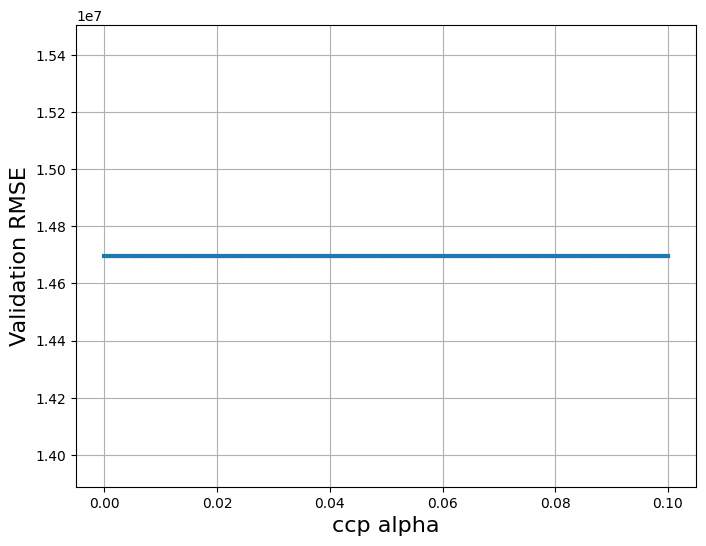

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('Validation RMSE', fontsize=16)
plt.scatter(ccp_alphas, rmse_scores, s=2)
plt.plot(ccp_alphas, rmse_scores, linewidth=3)
plt.grid(True, which='both')
plt.show()

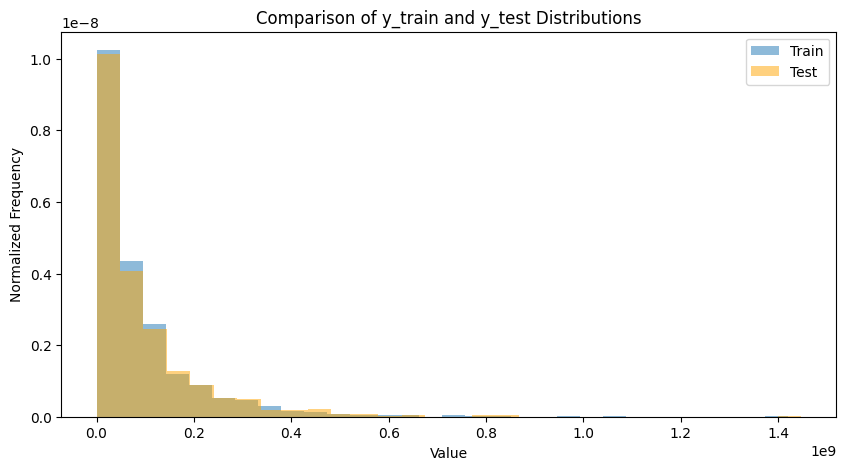

In [ ]:
import matplotlib.pyplot as plt

# Plot y_train and y_test
plt.figure(figsize=(10, 5))

plt.hist(y_train, bins=30, alpha=0.5, label='Train', density=True)  # density=True normalizes the histogram

plt.hist(y_test, bins=30, alpha=0.5, label='Test', color='orange', density=True)  # density=True normalizes the histogram

plt.title('Comparison of y_train and y_test Distributions')
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.show()

# Optimized Random Forest Model w/ GridSearchCV

## OSR2 = 0.982 when scoring is set to 'r2'

## RMSE = 16140461.14 when scoring is equal to 'neg_mean_squared_error'

***REMINDER: change scoring = "r2" or "neg_mean_squared_error" depending on what youwant to optimize for and also what metric you wanna see - either OSR2 or RMSE

In [ ]:
## using GridSearchCV to find best max_features:

import time
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

grid_values = {'max_features': np.linspace(1,27,27, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
# Change scoring from 'r2' or 'neg_mean_squared_error' to see difference in model performance based
# on optimization method
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='neg_mean_squared_error', cv=cv,verbose=2)
rf_cv.fit(X_train_dummies, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.7s
[CV] END max_features=2, min_samples_leaf=5, n_

# Run the cells below if scoring = 'r2' - skip if otherwise

(0.3, 1.0)

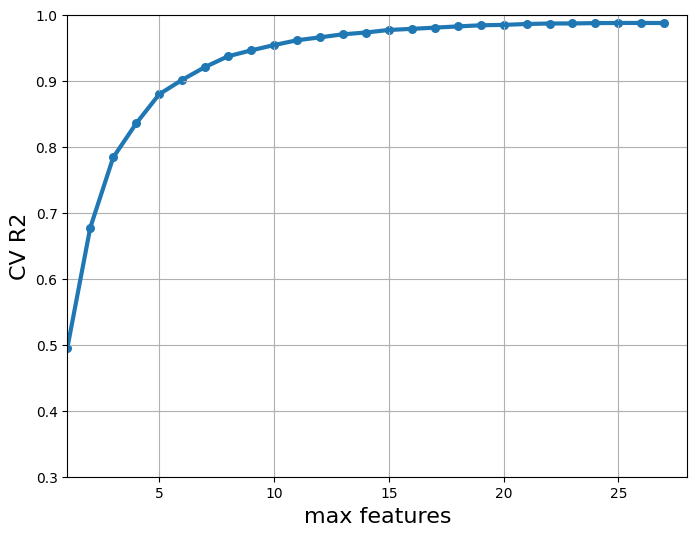

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 28])
plt.ylim([0.3, 1])

In [ ]:
print(rf_cv.best_params_)
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(dtr_OSR2(rf_cv, X_test_dummies, y_test, y_train), 5))

{'max_features': 26, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}
Cross-validated R2: 0.98754
OSR2: 0.98191


# Run the cells below if scoring = 'neg_mean_squared_error' - go back to r2 scoring method section above if otherwise

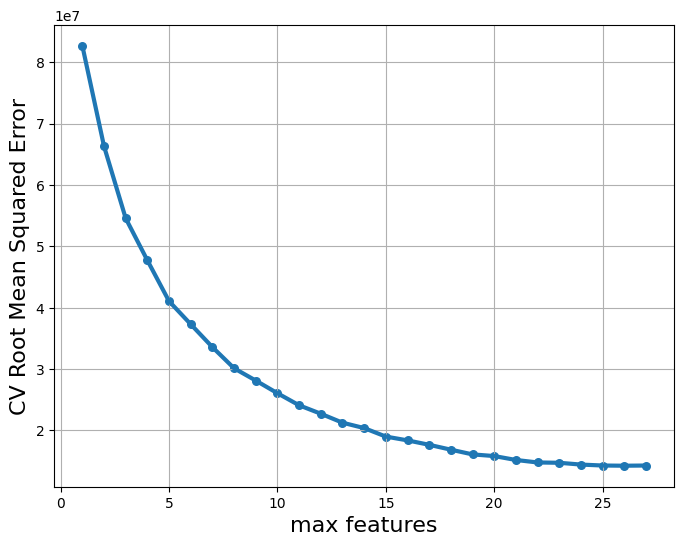

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
neg_mse_scores = rf_cv.cv_results_['mean_test_score']
mse_scores = -neg_mse_scores
rmse_scores = np.sqrt(mse_scores)

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV Root Mean Squared Error', fontsize=16)
plt.scatter(max_features, rmse_scores, s=30)
plt.plot(max_features, rmse_scores, linewidth=3)
plt.grid(True, which='both')

In [ ]:
print(rf_cv.best_params_)
print('Cross-validated Negative Mean Squared Error:', round(rf_cv.best_score_, 5))
print('Cross-validated Root Mean Squared Error:', round(np.sqrt(-rf_cv.best_score_), 2))

{'max_features': 26, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}
Cross-validated Negative Mean Squared Error: -202939528416126.7
Cross-validated Root Mean Squared Error: 14245684.55


In [ ]:
from sklearn.metrics import mean_squared_error
optimized_rf = RandomForestRegressor(max_features=26, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88)
# Note: you can change the verbose parameter to control how much training progress is printed.
optimized_rf.fit(X_train_dummies, y_train)
optimized_rf_y_preds = optimized_rf.predict(X_test_dummies)

optimized_rf_mse = mean_squared_error(y_test, optimized_rf_y_preds )

# Calculate Root Mean Squared Error (RMSE)
optimized_rf_test_rmse = round(np.sqrt(optimized_rf_mse), 2)

# print(f'Mean Squared Error (MSE): {optimized_rf_mse}')
# print(f'Root Mean Squared Error (RMSE): {optimized_rf_rmse}')
print(f'Optimized Random Forest Model Test Set Root Mean Squared Error (RMSE): {optimized_rf_test_rmse}')

Optimized Random Forest Model Test Set Root Mean Squared Error (RMSE): 16140461.14


# Boosting Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate= 0.1, max_leaf_nodes=100,
                                max_depth=100, min_samples_leaf=10, random_state=88, verbose=1) 
gbr.fit(X_train_dummies, y_train)

      Iter       Train Loss   Remaining Time 
         1 10871563727135736.0000            1.91s
         2 8837727262689890.0000            1.88s
         3 7189316411418002.0000            1.86s
         4 5853806101378101.0000            1.85s
         5 4771915152036768.0000            1.84s
         6 3897050126869270.0000            1.83s
         7 3186688516981835.5000            1.82s
         8 2611641702362269.0000            1.81s
         9 2145445525182110.0000            1.80s
        10 1767804855478038.5000            1.79s
        20 346274098605091.9375            1.70s
        30 165834301194684.8438            1.65s
        40 129616010628857.1719            1.57s
        50 114447316149706.3906            1.53s
        60 104604195981834.6562            1.51s
        70 96569284722885.0469            1.50s
        80 89189024112102.0312            1.50s
        90 80345751373860.8906            1.52s
       100 72459216497423.1875            1.55s
       200 31612

GradientBoostingRegressor(max_depth=100, max_leaf_nodes=100,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=88, verbose=1)

In [ ]:
print('OSR2:', round(dtr_OSR2(gbr, X_test_dummies, y_test, y_train), 5))

OSR2: 0.97779


# Boosting Model with CV

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True, random_state=88)
kfold_index = [] 
for index in kf.split(X_train_dummies):
    kfold_index.append(index)
# Each element of kfold_index is in the form of (kfold_index, kfold_index)

In [ ]:
# Define the grid (## I am using a subset of the original grid, to reduce the running time)
n_estimators = np.linspace(50, 75*50, 75, dtype='int32')
max_leaf_nodes = np.linspace(2, 10, 9, dtype='int32')  

In [ ]:
# Initialize the output array
R2_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
R2_array[:]=np.nan
RMSE_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
RMSE_array[:]=np.nan
MAE_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
MAE_array[:]=np.nan
print(R2_array.shape)

(75, 9)


In [ ]:
best_model_index = np.argmax(R2_array)
row_index = best_model_index//R2_array.shape[1]
col_index = best_model_index % R2_array.shape[1]
best_n_estimators = n_estimators[row_index]
best_max_leaf_nodes = max_leaf_nodes[col_index]
print('Best Model: n_estimator = %s, max_leaf_nodes = %s' %(best_n_estimators, best_max_leaf_nodes))

Best Model: n_estimator = 50, max_leaf_nodes = 2


In [ ]:
gbr_cv = GradientBoostingRegressor(n_estimators = best_n_estimators, learning_rate = 0.1, max_depth = 10,
                                max_leaf_nodes=best_max_leaf_nodes, min_samples_leaf=10,random_state=88,verbose=0)
gbr_cv.fit(X_train_dummies,y_train)

GradientBoostingRegressor(max_depth=10, max_leaf_nodes=2, min_samples_leaf=10,
                          n_estimators=50, random_state=88)

In [ ]:
print('OSR2:', round(dtr_OSR2(gbr_cv, X_test_dummies, y_test, y_train), 5))

OSR2: 0.96378


# RMSE CODE 

In [ ]:
optimized_gbr = GradientBoostingRegressor(n_estimators=200, learning_rate= 0.1, max_leaf_nodes=2,
                                max_depth=10, min_samples_leaf=10, random_state=88, verbose=1)
# Note: you can change the verbose parameter to control how much training progress is printed.
optimized_gbr.fit(X_train_dummies, y_train)
optimized_gbr_y_preds = optimized_gbr.predict(X_test_dummies)

optimized_gbr_mse = mean_squared_error(y_test, optimized_gbr_y_preds )

# Calculate Root Mean Squared Error (RMSE)
optimized_gbr_test_rmse = round(np.sqrt(optimized_gbr_mse), 2)

# print(f'Mean Squared Error (MSE): {optimized_rf_mse}')
# print(f'Root Mean Squared Error (RMSE): {optimized_rf_rmse}')
print(f'Optimized Gradient Boosting Regressor Model Test Set Root Mean Squared Error (RMSE): {optimized_gbr_test_rmse}')

      Iter       Train Loss   Remaining Time 
         1 11778983447453962.0000            0.62s
         2 10467502610033776.0000            0.58s
         3 9336485318063508.0000            0.59s
         4 8384897953215067.0000            0.59s
         5 7547650244512028.0000            0.59s
         6 6833764551606693.0000            0.59s
         7 6187725957409319.0000            0.58s
         8 5632757977194635.0000            0.59s
         9 5134762150198370.0000            0.58s
        10 4677744434038138.0000            0.57s
        20 2054070821814772.0000            0.53s
        30 1001342617247476.7500            0.49s
        40 545039377081409.6875            0.46s
        50 339486623015981.1250            0.43s
        60 246245519884515.8750            0.40s
        70 202572524067456.7500            0.37s
        80 182196236456865.4062            0.34s
        90 172123933268394.5938            0.31s
       100 167024978366858.7812            0.29s
       20

# Final Model Result Comparisons - Need to finish

In [ ]:
# Creating data
model_results_data = {
    'model': ["Baseline", "Linear Regression", "Decision Tree Regressor", "Random Forest", "Gradient Boosting"],
    'OSR2': [0.0, 0.982, 0.987, 0.982, 0.978],  
    'RMSE': [baseline_test_rmse, ols_test_rmse, 14696698.76, optimized_rf_test_rmse, optimized_gbr_test_rmse]     
}

# Creating DataFrame
model_results_df = pd.DataFrame(model_results_data)
model_results_df

,model,OSR2,RMSE
0,Baseline,0.000,1.200008e+08
1,Linear Regression,0.982,7.366435e+07
2,Decision Tree Regressor,0.987,1.469670e+07
3,Random Forest,0.982,1.614046e+07
4,Gradient Boosting,0.978,1.735716e+07
